# Решение заданий к уроку 6

In [1]:
import numpy as np
import random
import matplotlib.pyplot as plt
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import train_test_split
from sklearn.datasets import load_diabetes

__1.__Для реализованной в методичке модели градиентного бустинга построить графики зависимости ошибки от количества деревьев в ансамбле и от максимальной глубины деревьев. Сделать выводы о зависимости ошибки от этих параметров.

__2*.__ Модифицировать реализованный алгоритм, чтобы получился стохастический градиентный бустинг. Размер подвыборки принять равным 0.5. Сравнить на одном графике кривые изменения ошибки на тестовой выборке в зависимости от числа итераций.

__3*.__ Реализовать алгоритм градиетного бустинга, основанный на реализации решающего дерева из ДЗ4 / методички к уроку 4. Сделать выводы о качестве алгоритма по сравнению с реализацией из п.1.

### Решение


In [2]:
class GradientBoosting():
    def __init__(self, n_trees, max_depth, coefs, eta):
        self.n_trees = n_trees
        self.max_depth = max_depth
        self.coefs = coefs
        self.eta = eta
        
        # Создадим пустые списки для заполнения: список деревьев, список ошибок на train и на test
        self.trees = []
        self.train_errors = []
        self.test_errors = []
    
    def mse(self,y_real, prediction):
        return (sum((y_real - prediction)**2)) / len(y_real)
    def bias(self, y, z):
        return (y - z)
        
    def fit(self, X_train, X_test, y_train, y_test):        
        for i in range(self.n_trees):
            tree = DecisionTreeRegressor(max_depth=self.max_depth, random_state=42)
            # инициализируем бустинг начальным алгоритмом, возвращающим ноль, 
            # поэтому первый алгоритм просто обучаем на выборке и добавляем в список
            if len(self.trees) == 0:
                # обучаем первое дерево на обучающей выборке
                tree.fit(X_train, y_train)
                self.trees.append(tree)
                self.train_errors.append(self.mse(y_train, self.predict(X_train, self.trees, self.coefs, self.eta)))
                self.test_errors.append(self.mse(y_test, self.predict(X_test, self.trees, self.coefs, self.eta)))
            else:
                # Получим ответы на текущей композиции                
                target = self.predict(X_train, self.trees, self.coefs, self.eta)
                # алгоритмы начиная со второго обучаем на сдвиг
                tree.fit(X_train, self.bias(y_train,target))
                
                self.trees.append(tree)
                
                self.train_errors.append(self.mse(y_train, self.predict(X_train, self.trees, self.coefs, self.eta)))
                self.test_errors.append(self.mse(y_test, self.predict(X_test, self.trees, self.coefs, self.eta)))

    def predict(self, X, trees_list, coef_list, eta):
        # Реализуемый алгоритм градиентного бустинга будет инициализироваться нулевыми значениями,
        # поэтому все деревья из списка trees_list уже являются дополнительными и при предсказании прибавляются с шагом eta
        return np.array([sum([eta* coef * alg.predict([x])[0] for alg, coef in zip(trees_list, coef_list)]) for x in X])
       

In [3]:
X, y = load_diabetes(return_X_y=True)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25)

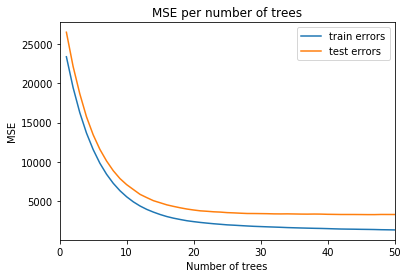

In [4]:
n_trees = 50
max_depth = 3
coefs = [1] * n_trees
eta = 0.1

model_gb = GradientBoosting(n_trees, max_depth, coefs, eta)
model_gb.fit(X_train, X_test, y_train, y_test)

train_errors_gb = model_gb.train_errors
test_errors_gb = model_gb.test_errors

x = list(range(1, n_trees+1))

plt.xlim(0, n_trees)
plt.plot(x, train_errors_gb, label='train errors')
plt.plot(x, test_errors_gb, label='test errors')
plt.title('MSE per number of trees')
plt.xlabel('Number of trees')
plt.ylabel('MSE')
plt.legend(loc='upper right')
plt.show()

Вывод: сначала при увеличении количества деревьем ошибка падает и на обучающей и на тестововой выборке, но при достижении количество деревьев 20-30 качество на тестовой выборке начинает ухудшаться. В данном случае оптимальное количество деревьев -порядка 20-25

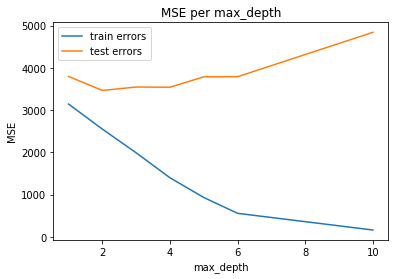

In [5]:
n_trees = 25
depths = [1,2,3,4,5,6,10]
# max_depth = 3
coefs = [1] * n_trees
eta = 0.1
train_err_depths = []
test_err_depths = []
for max_depth in depths:
    model_gb = GradientBoosting(n_trees, max_depth, coefs, eta)
    model_gb.fit(X_train, X_test, y_train, y_test)
    train_err_depths.append(model_gb.train_errors[-1])
    test_err_depths.append(model_gb.test_errors[-1])
    
plt.plot(depths, train_err_depths, label='train errors')
plt.plot(depths, test_err_depths, label='test errors')
plt.title('MSE per max_depth')
plt.xlabel('max_depth')
plt.ylabel('MSE')
plt.legend(loc='best')
plt.show()

Вывод: Оптимальная глубина дерева = 3

Теперь возьмем за основу свой класс по дереву решений

In [6]:
# Реализуем класс узла

class Node:
    
    def __init__(self, index, t, true_branch, false_branch):
        self.index = index  # индекс признака, по которому ведется сравнение с порогом в этом узле
        self.t = t  # значение порога
        self.true_branch = true_branch  # поддерево, удовлетворяющее условию в узле
        self.false_branch = false_branch  # поддерево, не удовлетворяющее условию в узле

# И класс терминального узла (листа)

class Leaf:
    
    def __init__(self, data, labels):
        self.data = data
        self.labels = labels
        self.prediction = self.predict()
        
    def predict(self):
        # подсчет количества объектов разных классов
        classes = {}  # сформируем словарь "класс: количество объектов"
        for label in self.labels:
            if label not in classes:
                classes[label] = 0
            classes[label] += 1
        #  найдем класс, количество объектов которого будет максимальным в этом листе и вернем его    
        prediction = max(classes, key=classes.get)
        return prediction     

In [7]:
class DecisionTree:
    
    def __init__(self, min_leaf, max_depth, criterion):
        self.min_leaf = min_leaf
        self.max_depth = max_depth
        self.criterion = criterion
        
        self.current_depth = 0
    
    # Расчет критерия

    def calc_criterion(self,labels):
        #  подсчет количества объектов разных классов
        classes = {}
        for label in labels:
            if label not in classes:
                classes[label] = 0
            classes[label] += 1

        #  расчет критерия
        if self.criterion == 'gini':
            criter = 1
            for label in classes:
                p = classes[label] / len(labels)
                criter -= p ** 2
#            print('gini', criter)
        elif self.criterion == 'entropy':
            criter = 0
            for label in classes:
                p = classes[label] / len(labels)
                criter -= p * np.log2(p)
#            print('entropy',criter)
        return criter
        
    # Расчет качества
    def quality(self, true_labels, false_labels, criter):        
        # доля выборки, ушедшая в левое поддерево
        p = float(true_labels.shape[0]) / (true_labels.shape[0] + false_labels.shape[0])
        return criter - p * self.calc_criterion(true_labels) - (1 - p) * self.calc_criterion(false_labels)         
        
    # Разбиение датасета в узле
    def split(self, data, labels, index, t):

        left = np.where(data[:, index] <= t)
        right = np.where(data[:, index] > t)

        true_data = data[left]
        false_data = data[right]
        true_labels = labels[left]
        false_labels = labels[right]

        return true_data, false_data, true_labels, false_labels 
        
    # Нахождение наилучшего разбиения
    def find_best_split(self, data, labels):

        criter = self.calc_criterion(labels)

        best_quality = 0
        best_t = None
        best_index = None
        
        n_features = data.shape[1]
    
        for index in range(n_features):
            # будем проверять только уникальные значения признака, исключая повторения
            t_values = np.unique([row[index] for row in data])

            for t in t_values:
                true_data, false_data, true_labels, false_labels = self.split(data, labels, index, t)
                #  пропускаем разбиения, в которых в узле остается менее min_leaf объектов
                if len(true_data) < self.min_leaf or len(false_data) < self.min_leaf:
                    continue

                current_quality = self.quality(true_labels, false_labels, criter)

                #  выбираем порог, на котором получается максимальный прирост качества
                if current_quality > best_quality:
                    best_quality, best_t, best_index = current_quality, t, index

        return best_quality, best_t, best_index
        
    # Построение дерева с помощью рекурсивной функции
    def build_tree(self, data, labels): 

        quality, t, index = self.find_best_split(data, labels)        

        #  Базовый случай - прекращаем рекурсию, когда нет прироста в качества
        if quality == 0:
            return Leaf(data, labels)
        
        # или когда достигаем максимальной глубины
        if self.current_depth <= self.max_depth:
            return Leaf(data, labels)
        
        true_data, false_data, true_labels, false_labels = self.split(data, labels, index, t)        

        # Рекурсивно строим два поддерева
        true_branch = self.build_tree(true_data, true_labels)
        false_branch = self.build_tree(false_data, false_labels)
        
        self.current_depth += 1

        # Возвращаем класс узла со всеми поддеревьями, то есть целого дерева        
        return Node(index, t, true_branch, false_branch)
    
    def classify_object(self, obj, node):
        #  Останавливаем рекурсию, если достигли листа
        if isinstance(node, Leaf):
            answer = node.prediction
            return answer

        if obj[node.index] <= node.t:
            return self.classify_object(obj, node.true_branch)
        else:
            return self.classify_object(obj, node.false_branch)

    def fit(self, data, labels):
        self.my_tree = self.build_tree(data, labels)
        
    def predict(self, data):        
        classes = []
        for obj in data:
            prediction = self.classify_object(obj, self.my_tree)        
            classes.append(prediction)
        return classes    

И реализуем градиентный бустинг на своей модели

In [15]:
class GradientBoostingMy():
    def __init__(self, n_trees, max_depth, coefs, eta):
        self.n_trees = n_trees
        self.max_depth = max_depth
        self.coefs = coefs
        self.eta = eta
        
        # Создадим пустые списки для заполнения: список деревьев, список ошибок на train и на test
        self.trees = []
        self.train_errors = []
        self.test_errors = []
    
    def mse(self,y_real, prediction):
        return (sum((y_real - prediction)**2)) / len(y_real)
    def bias(self, y, z):
        return (y - z)
        
    def fit(self, X_train, X_test, y_train, y_test):        
        for i in range(self.n_trees):
            tree = DecisionTree(min_leaf = 1, max_depth=self.max_depth, criterion='gini')
            # инициализируем бустинг начальным алгоритмом, возвращающим ноль, 
            # поэтому первый алгоритм просто обучаем на выборке и добавляем в список
            if len(self.trees) == 0:
                # обучаем первое дерево на обучающей выборке
                tree.fit(X_train, y_train)
                self.trees.append(tree)
                self.train_errors.append(self.mse(y_train, self.predict(X_train, self.trees, self.coefs, self.eta)))
                self.test_errors.append(self.mse(y_test, self.predict(X_test, self.trees, self.coefs, self.eta)))
            else:
                # Получим ответы на текущей композиции                
                target = self.predict(X_train, self.trees, self.coefs, self.eta)
                # алгоритмы начиная со второго обучаем на сдвиг
                tree.fit(X_train, self.bias(y_train,target))
                
                self.trees.append(tree)
                
                self.train_errors.append(self.mse(y_train, self.predict(X_train, self.trees, self.coefs, self.eta)))
                self.test_errors.append(self.mse(y_test, self.predict(X_test, self.trees, self.coefs, self.eta)))

    def predict(self, X, trees_list, coef_list, eta):
        # Реализуемый алгоритм градиентного бустинга будет инициализироваться нулевыми значениями,
        # поэтому все деревья из списка trees_list уже являются дополнительными и при предсказании прибавляются с шагом eta
        return np.array([sum([eta* coef * alg.predict([x])[0] for alg, coef in zip(trees_list, coef_list)]) for x in X])
       

In [20]:
n_trees = 20
max_depth = 3
coefs = [1] * n_trees
eta = 0.1


model_gb = GradientBoosting(n_trees, max_depth, coefs, eta)
model_gb.fit(X_train, X_test, y_train, y_test)
train_errors_gb = model_gb.train_errors
test_errors_gb = model_gb.test_errors

model_gb_my = GradientBoostingMy(n_trees, max_depth, coefs, eta)
model_gb_my.fit(X_train, X_test, y_train, y_test)
train_errors_gb_my = model_gb_my.train_errors
test_errors_gb_my = model_gb_my.test_errors

print(f'n\ttrain_err \t\ttest_err \t\ttrain_err_my \t\ttest_err_my')
print('-'*100)
for i in range(n_trees):
    print(f'{i}\t{train_errors_gb[i]}\t{test_errors_gb[i]}\t{train_errors_gb_my[i]}\t{test_errors_gb_my[i]}')

n	train_err 		test_err 		train_err_my 		test_err_my
----------------------------------------------------------------------------------------------------
0	23371.00269287916	26490.905744981108	26101.449667673733	29423.020180180192
1	19451.287177581962	22147.75783725902	24300.269650755276	27481.803661261252
2	16266.198449172718	18664.489415884567	22751.0112195287	25806.512378234245
3	13668.574730101398	15735.348793041756	21414.839534464772	24356.911126549912
4	11563.9773749733	13444.197532222235	20259.39534936964	23099.380331496406
5	9828.493588125573	11593.567685095823	19257.654951268552	22005.76198443283
6	8425.860248049044	10111.389079403882	18386.997681450073	21052.41456054806
7	7272.846569733597	8874.971224165605	17628.44250027615	20219.438240714488
8	6329.4050017197815	7874.501104439997	16966.02229016642	19490.039005811068
9	5558.356589666864	7104.01336349836	16386.270457954513	18850.006051284887
10	4914.4226827253215	6484.346635967452	15877.799158042246	18287.281741289713
11	4387.

Алгоритм градиетного бустинга, основанный на реализации из своего решающего дерева работает хуже по сравнению с реализацией из п.1. 